In [1]:
# import required libraries
import math as math              # for maths functions such as sqrt, log10, fmod
import numpy as np               # for array of state data
import matplotlib.pyplot as plt  # for plotting
import matplotlib.gridspec as gridspec
import time                      # for recording cpu time
import random
from scipy import fft
# Own Libraries
from Control_MYO.PIDs import PID, PID_OnRate
from Control_MYO import LQR, Integrators , Filters
from Control_MYO.IBSs import IBS, IBS_NL, IBS_NL_RudDyn, IBS_NL_LPN, IBS_NL_LPN_RudDyn1, IBS_NL_LPN_RudDyn2
from Control_MYO.DynamicModels import Nomoto1st, Nomoto1st_FF, Nomoto1stNL, Nomoto1st_FL, Nomoto1stNL_FF, Nomoto1stNL_RudDyn1, Nomoto1stNL_RudDyn2, BechWenger3rdNL, SteeringGear
from Control_MYO.Helpers import clamp, pi2pi
from Control_MYO.SMCs import SMC, SMC_NL

In [2]:
# Plot
def plot(t_vec,x_mat,u_mat, x_d_mat):
    fig = plt.figure()
#    gs = gridspec.GridSpec(2, 1, figure=fig)
    ax1 = fig.add_subplot(411)
    ax1.plot(t_vec, x_mat[0,:]*180/math.pi)
    ax1.plot(t_vec, x_d_mat[0,:]*180/math.pi)
    ax1.grid()
    
    ax2 = fig.add_subplot(412)
    ax2.plot(t_vec, x_mat[1,:]*180/math.pi)
    ax2.plot(t_vec, x_d_mat[1,:]*180/math.pi)
    ax2.grid()

    ax3 = fig.add_subplot(413)
    ax3.plot(t_vec, x_mat[2,:]*180/math.pi)
    ax3.plot(t_vec, x_d_mat[2,:]*180/math.pi)
    ax3.grid()
    
    ax3 = fig.add_subplot(414)
    ax3.plot(t_vec, u_mat[0,:]*180/math.pi)
    ax3.grid()
    fig.savefig("test.png")
    plt.show()

def plotSMC(t_vec, sigma, error_vec, x_mat):
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    ax1.plot(t_vec, sigma)
    ax1.grid()

    ax2 = fig.add_subplot(312)
    ax2.plot(error_vec[0,], error_vec[1,])
    ax2.grid()

    ax3 = fig.add_subplot(313)
    ax3.plot(x_mat[0,], x_mat[1,])
    ax3.grid()

    plt.show()


Simulation Start!
LQR Gains:-K [[-1.         -5.03809785]]
Nonlinear Lyapunov-based IBS with Ruuder Dynamics object created!
SMC with Nonlinear Nomoto Model Object Created!
Simulation Finished!
cpuTime: 8.49 sec
178.9999951221759


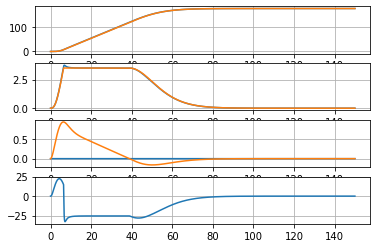

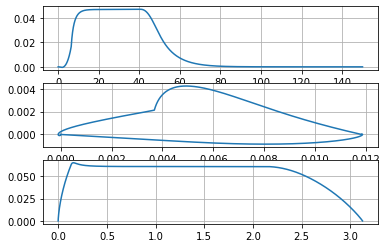

In [3]:
# MAIN PROGRAM
# Initial Conditions
psi0 = 0*math.pi/180
r0   = 0
x0   = np.array([psi0, r0])

delta0 = 0
u0 = np.array([delta0])

# Start, Finish, Time Step
t0 = 0
tF = 100*1.5
dt = 0.001

# PID Gains (Fossen EO PID_Gain = [41.7422, 0.0587, 77.6189])
# Previous PID Gain = [3, 0.05, 25]
KP = 41.7422
KI = 0.0587
KD = 77.6189
PID_Gains = np.array([KP, KI, KD])

# # For PIDAutopilot
# KP = 10
# KI = 0.05
# TD = 50
# TE = 2
# PID_Gains = np.array([KP, KI, TD, TE]) # For PIDAutopilot

## For LQR
K = 0.1705
T = 7.1167
KR = 1 # [rad]
TR = 5 # [s]
A = np.array([[0, 1],
              [0, -1/T]])
B = np.array([[0],
              [K/T]])
# C = np.array([[1, 0]])
Q = np.array([[1, 0],
              [0, 1]])
R = np.array([[1]])

# # For FL-LQR
# n1 = -1
# A = np.array([[0, 1],
#               [0, -n1/T]])
# B = np.array([[0],
#               [1]])
# # Q = np.array([[1, 0],
# #               [0, 1]])
# C = np.array([[1, 0]])
# Q = C.T@np.eye(1)@C
# R = np.array([[1]])

# # For Integral LQR
# A = np.array([[0, 1, 1],
#               [0, 0, 1],
#               [0, 0, -1/T]])
# B = np.array([[0],
#               [0],
#               [K/T]])

# Q = np.array([[0, 0, 0],
#               [0, 1, 0],
#               [0, 0, 1]])
# R = np.array([[1]])
I_error = 0
              
delta_max = 40*math.pi/180
delta_rate_max = 60*math.pi/180
u_bound = np.array([-delta_max, delta_max])
u_rate_bound = np.array([-delta_rate_max, delta_rate_max])
delta_state = 0

######################## Simulate ########################
#--------------------------------------------------------#
t_start = time.time() # to record cpuTime
print("Simulation Start!")
psi_ref = 179*math.pi/180
x_ref = np.array([psi_ref, 0])

# x = x0
x = np.append(x0, 0) # 3 Sates
u = np.array([u0])
p = 0.006*0 # Parameter in Nomoto Model
Integral   = 0
x_filter   = 0
omega_f    = 100

# For Reference Generator
# x_d = np.array([psi0, r0]) # For 2nd order RefGen
# x_d = np.array([psi0, r0, 0]) # For 3rd order RefGen
x_d = np.array([psi0, r0, 0, 0]) # For 4th order RefGen
omega_n = 0.45-0.25  # How fast the psi_d converged to psi_ref (0.45 from Fossen)
zeta    = 1 # (1 from Fossen)
r_d_max = 3.5*(math.pi/180)

K_add = 0 # Added Inertia in Feedforward Term (0 to 1)

t_vec = np.arange(t0,tF,dt)
x_mat = np.zeros((x0.size+1, t_vec.size))
x_d_mat = np.zeros((x0.size+2, t_vec.size))
u_mat = np.zeros((u0.size, t_vec.size))
sigma = np.zeros((t_vec.size))
error_vec = np.zeros((2, t_vec.size))

x_PID = np.array([[0],
                  [0]]) # Filtered PID
N = 1 # filtered coefficient (should tune together with PID gains)

Noise_Amp = 0.001*0
# myPID = PID(KP, KI, KD, u_bound)
myPID2 = PID_OnRate(KP, KI, KD, u_bound)

# myLQR = LQR(A, B, C.T@Q@C, R, u_bound)
myLQR = LQR(A, B, Q, R, u_bound)
# myIBS = IBS(K, T, 0.1, 1, u_bound) # 0.3, 100
# myIBS = IBS_NL(K, T, 0.1, 0.5, u_bound) # 0.3, 100

# myIBS = IBS_NL_RudDyn(K, T, TR, 0.2, 1, 3, u_bound) # IBS_NL_LPN_RudDyn needs 4th order ref gen, 3rd state is delta
# myIBS = IBS_NL_LPN(K, T, 0.005, 150, u_bound) # [0.005, 150] IBS_NL_LPN needs 3rd order ref gen

# A Tanker
# L = 350 # [m]
# V = 5 # [m/s]

# Tanker (Ballast Condition)
# K0 = 5.88
# T10 = -16.91
# T20 = 0.45
# T30 = 1.43
# T0 = T10 + T20 - T30
# T = T0*(L/V)
# K = K0*(V/L)
# KR = 96*math.pi/180 # [rad]
# TR = 156 # [s]

# myIBS = IBS_NL_LPN_RudDyn1(K, T, KR, TR, 0.1, 100, 1, u_bound) # [0.1, 100, 1] IBS_NL_LPN_RudDyn1 needs 4th order ref gen, 3rd state is delta
myIBS = IBS_NL_LPN_RudDyn2(K, T, KR, TR, 0.1, 0.1, 50, u_bound) # [0.1, 100, 1] IBS_NL_LPN_RudDyn2 needs 4th order ref gen, 3rd state is psi_dddot

# mySMC = SMC([1, 4], 10, u_bound)
mySMC = SMC_NL(4, 0.1, u_bound) # when p=0.006, k=0.1 (original = 10)
x_d0_last = 0

idx = 0
for t in t_vec:

    psi = x[0] + (random.uniform(-1,1))*Noise_Amp
    # psi, x_filter = Filters.Lowpass1st(x_filter, psi, omega_f, dt)
    # psi = pi2pi(psi) # Rewrite with -pi and pi
    psi_ref = pi2pi(psi_ref)
    error = psi_ref - psi
    # error = pi2pi(error)
    r = x[1]
    
    #     x_d = Filters.RefGen2nd(x_d, psi_ref, omega_n, zeta, dt, r_d_max)
    # x_d = Filters.RefGen3rd(x_d, psi_ref, omega_n, zeta, dt, r_d_max)
    x_d = Filters.RefGen4th(x_d, psi_ref, omega_n, zeta, zeta, dt, r_d_max)

    # u = myPID(error, dt)
    # u = -myPID2(psi - x_d[0], r - x_d[1], dt)/K 
    # divided by K since output from PID_OnRate is tuned for Yaw Moment, not Rudder angle (tau_yaw = K*delta)
    
    # x[0] = psi

    I_error += -error*dt
    # error_vec = x[:2] - x_d[:2]
    # u, _ = myLQR(np.append(I_error,error_vec)) 
    # u, _ = myLQR(error_vec)
    # u = Nomoto1st_FL(x, u) # Nonlinear Control Mapping
    # 
    # u = myIBS(x, x_d) 
    # u = myIBS(np.append(x[:2],u), x_d) 
    # u = myIBSRud(np.append(x, 0), x_d)
    # u = myIBSRud(x, x_d)

    u, sigma[idx]  = mySMC(x, x_d)

    # u_FF = Nomoto1st_FF(x_d, K_add) # Need 3rd order Ref Gen
    # u_FF = Nomoto1stNL_FF(x_d, K_add) # Need 3rd order Ref Gen
    # u = u + u_FF

    # u = u + 0.007*I_error # Direct Integral Effect
    u = clamp(u, u_bound[0], u_bound[1])
    error_last = error
    u = np.array([u])

    # u, delta_dot = SteeringGear(delta_state, u, KR, TR, u_bound[0], u_rate_bound[0], dt)
    x = Integrators.RKGill(Nomoto1stNL,t,x,u,p,dt)   # Select Integration Method
    # x = Integrators.RKGill(Nomoto1stNL_RudDyn2,t,x,u,p,dt) # This can only be controlled by BS_NL_LPN_RudDyn(1) and 2, 1 implmentation is not corrected yet, x3 should be delta instead of psi_dddot
    # x = Integrators.RKGill(Nomoto1stNL_RudDyn1,t,x,u,p,dt) # still uncontrollable
    # x = Integrators.RKGill(BechWenger3rdNL,t,x,u,delta_dot,dt) 

    # Save State and Control Data
    x_mat[:,idx] = x[:3]
    u_mat[:,idx] = u
    x_d_mat[:,idx] = x_d
    error_vec[:,idx] = x[:2] - x_d[:2]

    idx += 1
del myLQR, myPID2, myIBS
print("Simulation Finished!")
t_end   = time.time() # to record cpuTime
#--------------------------------------------------------#
##########################################################

cpuTime = round(t_end - t_start,2)
print("cpuTime:",cpuTime, "sec")

print(x_mat[0,-1]*180/math.pi)
plot(t_vec,x_mat,u_mat, x_d_mat) # call plot function
plotSMC(t_vec, sigma, error_vec, x_mat)